# Companion code for [Rough Bergomi turns grey](https://arxiv.org/abs/2505.08623)
---
(Authors: A. Jacquier, A. Oliveri Orioles, Z. Zuric)

The grey Bergomi model is defined by the following system of stochastic differential equations:
\begin{align*}
\frac{\mathrm{d}S_t}{S_t} & := \int_0^t \sqrt{V_u} \left(\rho \mathrm{d}B_u + \sqrt{1-\rho^2} \mathrm{d}W_u\right), & S_0 > 0,\\
V_t & := \xi(t)\mathcal{E}_{\beta}\left(\mathfrak{b} t^{2H}\right)^{-1} \exp\left\{\eta \mathfrak{c} Y_{\beta}\int^t_0 (t-u)^{H - \frac{1}{2}} \mathrm{d}B_u\right\}, & V_0 > 0,
\end{align*}
where $\xi(\cdot)>0$ is the initial forward variance, $\eta > 0$ is the volatility-of-volatility, $Y_{\beta}$ is a one-sided M-Wright random variable with scale $\beta$, and $B$ and $W$ are two independent Brownian motions. Furthermore, $\mathfrak{c} := \frac{1}{\Gamma(H + \frac{1}{2})}$ and $\mathfrak{b} := \frac{\eta^2 \mathfrak{c}^2}{4H}$.

We provide several examples on using the model to price options, VIX Futures, and to showcase asymptotic formulae.

In [6]:
import numpy as np
import matplotlib.pyplot as plt

from grey_bergomi.gBergomi import gBergomi, gBergomiVIX, VIXSkewAsymptotics, VIXCurvatureAsymptotics, VIXImpliedVolAsymptotics, SPXSkewAsymptotics
from utils import bsinv

In [7]:
vec_bsinv = np.vectorize(bsinv)

## Option pricing under gBergomi

#### Definition of the pricing function

In [10]:
np.random.seed(42)

def gBergomi_Calls_ImpliedVols(logmoneyness_range, nbTimeSteps, npPaths, a, beta, rho, T):
    """
    Simulate European call option prices and implied volatilities under the
    gBergomi model.

    Parameters
    ----------
    logmoneyness_range : array_like
        Range of log-moneyness values, i.e. log(K / S0). Strike prices are
        obtained as K = exp(logmoneyness_range) assuming spot S0 = 1.
    nbTimeSteps : int
        Number of time discretisation steps for the simulation.
    npPaths : int
        Number of Monte Carlo simulation paths.
    a : float
        Roughness parameter of the Volterra kernel.
    beta : float
        Volatility-of-volatility scaling parameter.
    rho : float
        Correlation between the Brownian motions of spot and volatility.
    T : float
        Option maturity (in years).

    Returns
    -------
    call_prices : np.ndarray, shape (len(logmoneyness_range),)
        Monte Carlo estimated European call prices for each strike.
    implied_vols : np.ndarray, shape (len(logmoneyness_range),)
        Black–Scholes implied volatilities corresponding to the simulated call prices.
    """
    K = np.exp(logmoneyness_range)
    
    # Initialise ggBergomi class
    gB = gBergomi(n = nbTimeSteps, N = npPaths, T=T, a=a, b=beta)
    
    # Generate Brownian motions
    dW1 = gB.dW1()
    dW2 = gB.dW2()
    
    # Generate Volterra process
    Y = gB.Y(dW1)
    
    # Correlate the Brownian motions
    dB = gB.dB(dW1, dW2, rho)
    
    # Simulate the variance and spot processes
    V = gB.V(Y, xi, eta)
    S = gB.S(V, dB)
    
    # Compute call payoffs and implied volatilities
    ST = S[:,-1][:,np.newaxis]
    call_payoffs = np.maximum(ST - K, 0)
    call_prices = np.mean(call_payoffs, axis = 0)
    implied_vols = vec_bsinv(call_prices, 1., np.transpose(K), gB.T)
    return call_prices, implied_vols

#### Numerical example

In [34]:
nbTimeSteps, npPaths = 300, 10000
a, beta, rho, T = -0.43, 0.9, -.7, .5
xi, eta = 0.235**2, 2
logmoneyness_range = np.arange(-0.2, 0.21, 0.01)

call_prices, implied_vols = gBergomi_Calls_ImpliedVols(logmoneyness_range, nbTimeSteps, npPaths, a, beta, rho, T)

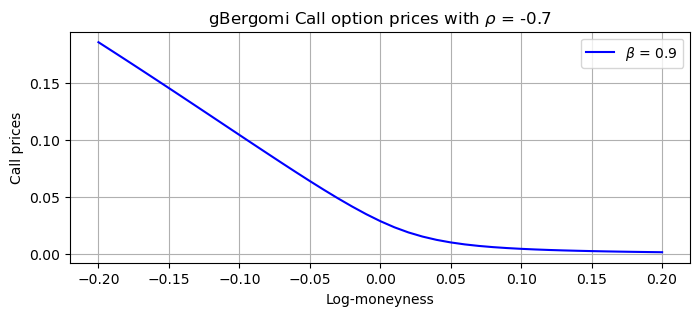

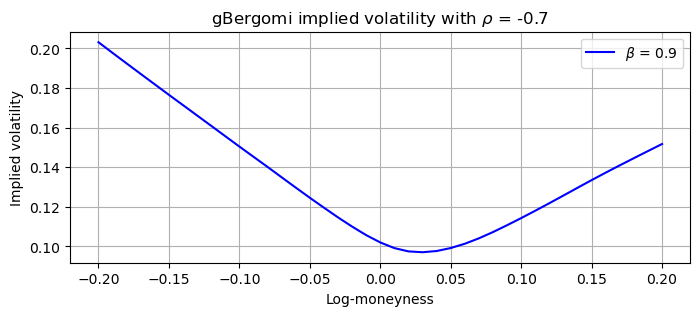

In [35]:
plt.figure(figsize = (8,3))
plt.plot(logmoneyness_range, call_prices, color = 'blue', label = r'$\beta$ = %.1f' %beta)
plt.xlabel('Log-moneyness')
plt.ylabel('Call prices')
plt.title(r'gBergomi Call option prices with $\rho$ = %.1f' %rho)
plt.legend(loc='best')
plt.grid()
plt.show()


plt.figure(figsize = (8,3))
plt.plot(logmoneyness_range, implied_vols, color = 'blue', label = r'$\beta$ = %.1f' %beta)
plt.xlabel('Log-moneyness')
plt.ylabel('Implied volatility')
plt.title(r'gBergomi implied volatility with $\rho$ = %.1f' %rho)
plt.legend(loc='best')
plt.grid()
plt.show()

#### Comparisons

In [43]:
betas = [.6, .9, 1.]

<Figure size 800x300 with 0 Axes>

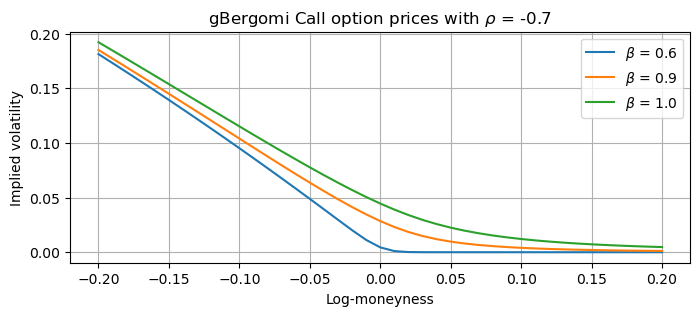

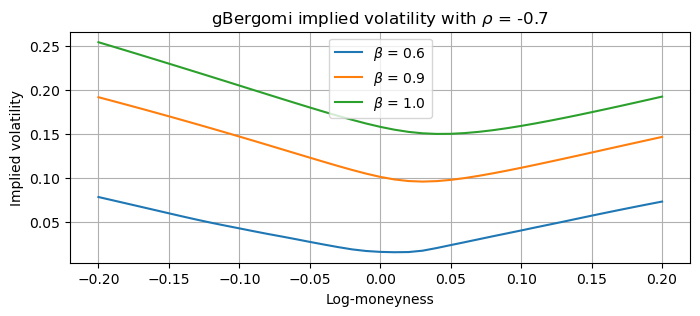

In [45]:
nbTimeSteps, npPaths = 600, 200000
call_prices, implied_vols = [], []

plt.figure(figsize = (8,3))
for beta in betas:
    cp, iv = gBergomi_Calls_ImpliedVols(logmoneyness_range, nbTimeSteps, npPaths, a, beta, rho, T)
    call_prices.append(cp)
    implied_vols.append(iv)


plt.figure(figsize = (8,3))
for (beta, cp) in zip(betas, call_prices):
    plt.plot(logmoneyness_range, cp, label = r'$\beta$ = %.1f' %beta)
plt.xlabel('Log-moneyness')
plt.ylabel('Implied volatility')
plt.title(r'gBergomi Call option prices with $\rho$ = %.1f' %rho)
plt.legend(loc='best')
plt.grid()
plt.show()

plt.figure(figsize = (8,3))
for (beta, iv) in zip(betas, implied_vols):
    plt.plot(logmoneyness_range, iv, label = r'$\beta$ = %.1f' %beta)
plt.xlabel('Log-moneyness')
plt.ylabel('Implied volatility')
plt.title(r'gBergomi implied volatility with $\rho$ = %.1f' %rho)
plt.legend(loc='best')
plt.grid()
plt.show()

## VIX Futures pricing under gBergomi

In [58]:
# Initialise gBergomi VIX class
vix = gBergomiVIX(n = 50, N = 30, H = 0.07, eta = 1.23, beta = 0.9, xi = lambda x: 0.235 ** 2, mc_sims = 10000, T = 1.)

# Simulate VIX process
vix.vix_pricing()

# Calculate VIX Futures
futures = np.mean(vix.vix_matrix, axis = 0)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:16<00:00, 73.34it/s]


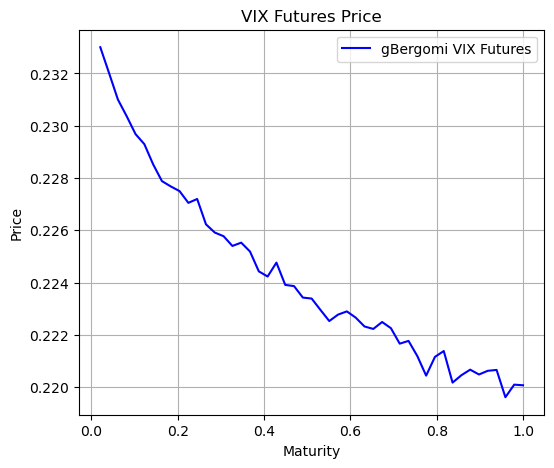

In [60]:
plt.figure(figsize = (6,5))
plt.plot(vix.time_grid[1:], futures, color = 'blue', label = 'gBergomi VIX Futures')
plt.xlabel('Maturity')
plt.ylabel('Price')
plt.title('VIX Futures Price')
plt.legend(loc = 'best')
plt.grid()
plt.show()

## Asymptotic Formulae under gBergomi
---
The VIX and SPX asymptotic formulae can be found in Proposition 4.2 and Proposition 4.6 respectively, in the original paper [Rough Bergomi turns grey](https://arxiv.org/abs/2505.08623).

In [63]:
alpha = 0.14
eta = 1.2287
beta_array = np.linspace(0.001,0.999,100)
xi = 0.235 ** 2
rho = -1

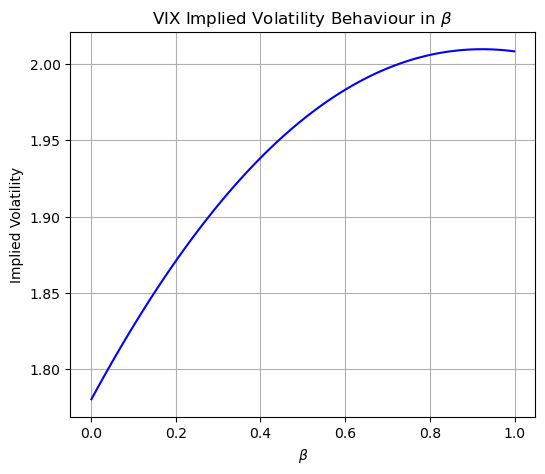

In [65]:
plt.figure(figsize = (6,5))
plt.plot(beta_array, VIXImpliedVolAsymptotics(xi, alpha, beta_array, eta), color = 'blue')
plt.xlabel(r'$\beta$')
plt.ylabel('Implied Volatility')
plt.title(r'VIX Implied Volatility Behaviour in $\beta$')
plt.grid()
plt.show()

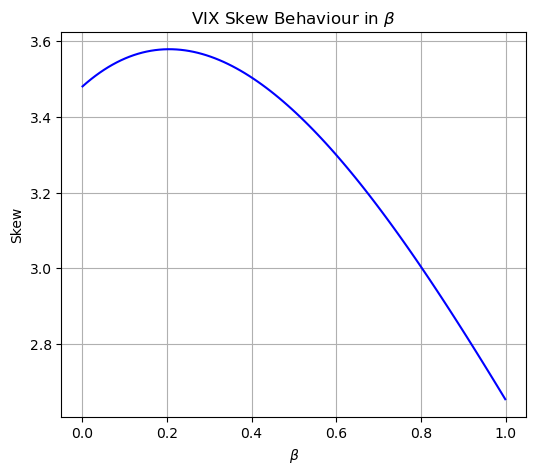

In [67]:
plt.figure(figsize = (6,5))
plt.plot(beta_array, VIXSkewAsymptotics(xi, alpha, beta_array, eta), color = 'blue')
plt.xlabel(r'$\beta$')
plt.ylabel('Skew')
plt.title(r'VIX Skew Behaviour in $\beta$')
plt.grid()
plt.show()

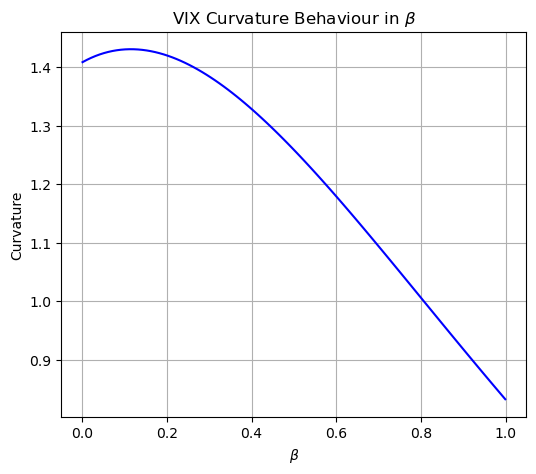

In [69]:
plt.figure(figsize = (6,5))
plt.plot(beta_array, VIXCurvatureAsymptotics(xi, alpha, beta_array, eta), color = 'blue')
plt.xlabel(r'$\beta$')
plt.ylabel('Curvature')
plt.title(r'VIX Curvature Behaviour in $\beta$')
plt.grid()
plt.show()

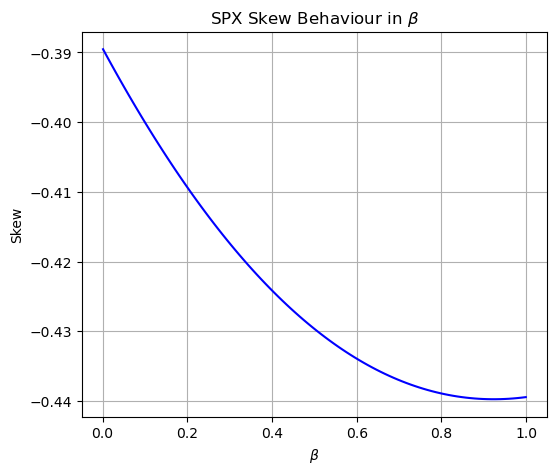

In [70]:
plt.figure(figsize = (6,5))
plt.plot(beta_array, SPXSkewAsymptotics(alpha, beta_array, rho, eta), color = 'blue')
plt.xlabel(r'$\beta$')
plt.ylabel('Skew')
plt.title(r'SPX Skew Behaviour in $\beta$')
plt.grid()
plt.show()